# Example 2

In this notebook we show the iterative optimization of unknown function using Bayessian Optimization process. In a nutshell, we run iteratively the process described in Example 1:
- Train model using known data
- Assess acquisition function given the model 
- Pick a new point
- Measure funciton in the new point and add it to the tknow data.
- Repeat

In [2]:
# Necessary imports
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from pylab import meshgrid
import matplotlib.pyplot as plt
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we define function used to describe "real" model. This function plays role of pseudoexperiment - in real life it is unknown, we do experiments to measure it in proposed points, and our algorithm aims to find its global minimum. Now we use [benchmark-functions](https://gitlab.com/luca.baronti/python_benchmark_functions) library to pick a function.

In [14]:
import benchmark_functions as bf

# target_func = bf.Griewank(n_dimensions=2, zoom = 2, opposite = True)
target_func = bf.Hypersphere(n_dimensions = 2, opposite = True)

def func(x):
    """Auxilary funciton to apply target function to tensor.
    We transform axis so that ranges of all axis are [0, 1]
        
    Inputs:
        x -  tensor of input data. Size of the last dimension mattch dimensionality of data
        func - function of `dim`
    """
    y = []
    bounds = np.array(target_func.suggested_bounds())
    for xi in x.view(np.prod(x.shape[:-1]),x.shape[-1]).tolist():
        _xi = np.array(xi)*(bounds[1]-bounds[0])+bounds[0]
        y.append(target_func(_xi))
    y = torch.FloatTensor(y).reshape(x.shape[:-1]+torch.Size([1]))
    return y    

In [15]:
n_start = 2
n_extra = 10

train_X = torch.rand(n_start, 2)

In [16]:
def next_data_point(train_X, func):
    """This function creates runs botorch optimisaiton over the given dataset and returns the next point.
    
    Inputs:
        train_X - tensor of the shape (size, dim)
        func - function taking data point(s) and returning tensor of values
    Output:
        data_point - tensor of the shape (1, dim)
    """
    
    # Getting values of target function in train points
    train_Y = func(train_X) 
    # Defining the model
    gp = SingleTaskGP(train_X, train_Y)
    # Defining cost function
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    # Set model's parameters to those that maximize likelihood.
    fit_gpytorch_model(mll)
    # Defining acquisition function
    ei = ExpectedImprovement(gp, best_f = train_Y.max())
    # Domain of the target function.
    data_dim =  train_X.shape[-1]
    bounds = torch.stack([torch.zeros(data_dim), torch.ones(data_dim)])
    # Botorch suggestion
    candidate, acq_value = optimize_acqf(
        ei, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    return candidate

Let's run the iterative process. We will start with 2 data points and ask BoTorch to select the next 10.

In [17]:
n_start = 2
n_extra = 10

train_X = torch.rand(n_start, 2)

for i in range(1, 1+n_extra):
    candidate = next_data_point(train_X, func)
    train_X = torch.cat((train_X,candidate), 0)


Let's see how these points are spread over the parameter space.

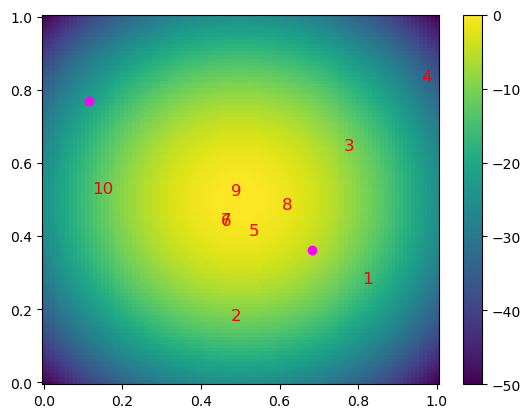

In [18]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
xy = torch.cat((torch.unsqueeze(torch.tensor(X), dim=-1), torch.unsqueeze(torch.tensor(Y), dim=-1)), dim = -1)
Z = func(xy)
Z = torch.squeeze(Z, dim = -1)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z)
ax.scatter(train_X[:n_start].T[0], train_X[:n_start].T[1], color = 'magenta')
for i in range(1, 1+n_extra):
     plt.text(train_X[1+i,...].T[0], train_X[1+i,...].T[1], str(i), color="red", fontsize=12)
plt.colorbar(m) # adding the colobar on the right
